<a href="https://colab.research.google.com/github/RichardCYC/Bike_sharing_demand_prediction/blob/main/Bike_share_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive to get data

from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/Colab_Notebooks') 
os.getcwd() 

Mounted at /content/gdrive


'/content/gdrive/MyDrive/Colab_Notebooks'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # ignore warnings
from IPython.display import display
from sklearn.preprocessing import LabelEncoder

In [ ]:
# read data
df = pd.read_csv('Bike_share_prediction/train.csv') 
df_test = pd.read_csv('Bike_share_prediction/test.csv') 
df = pd.concat([df, df_test]).reset_index() # 也可寫成 df = df.append(df_test).reset_index()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   datetime    17379 non-null  object 
 2   season      17379 non-null  int64  
 3   holiday     17379 non-null  int64  
 4   workingday  17379 non-null  int64  
 5   weather     17379 non-null  int64  
 6   temp        17379 non-null  float64
 7   atemp       17379 non-null  float64
 8   humidity    17379 non-null  int64  
 9   windspeed   17379 non-null  float64
 10  casual      10886 non-null  float64
 11  registered  10886 non-null  float64
 12  count       10886 non-null  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 1.7+ MB


In [ ]:
df['date'] = df['datetime'].apply(lambda x:x[:10])
df['hour'] = df['datetime'].apply(lambda x:x[11:])
df['month'] = df['datetime'].apply(lambda x:x[5:7])
df['day'] = df['datetime'].apply(lambda x:x[8:10])
df['yearmonth'] = df['datetime'].apply(lambda x:x[:7])

In [ ]:
df_monthcount = df.groupby('yearmonth').mean()['count'].reset_index()

# 處理月份名稱（改為後一月）
df_monthcount['yearmonth'] = df_monthcount['yearmonth'].apply(lambda x:str(int(x[:4])+1)+'-01' if '-12' in x else (str(x[:6])+str(int(x[-1])+1) if str(x[-2:]) != '09' else str(x[:5])+str(int(x[-1])+1)))

In [ ]:
df = df.merge(df_monthcount, on = 'yearmonth', how = 'left')
df = df.rename(columns={'count_x': 'count', 'count_y': 'premonth_count'})

In [ ]:
# 針對欄位做scaling
from sklearn.preprocessing import StandardScaler
df[['temp']] = StandardScaler().fit_transform(df[['temp']]) # scaling 的欄位要是2d dimension，所以多加一個括號
df[['humidity']] = StandardScaler().fit_transform(df[['humidity']])

In [ ]:
# 沒有前一月就塞入當月資料
df['premonth_count'] = np.where(df['yearmonth']== '2011-01', df_monthcount['count'].iloc[0], df['premonth_count'])

In [ ]:
df_train = df[df['count'].notnull()]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           10886 non-null  int64  
 1   datetime        10886 non-null  object 
 2   season          10886 non-null  int64  
 3   holiday         10886 non-null  int64  
 4   workingday      10886 non-null  int64  
 5   weather         10886 non-null  int64  
 6   temp            10886 non-null  float64
 7   atemp           10886 non-null  float64
 8   humidity        10886 non-null  float64
 9   windspeed       10886 non-null  float64
 10  casual          10886 non-null  float64
 11  registered      10886 non-null  float64
 12  count           10886 non-null  float64
 13  date            10886 non-null  object 
 14  hour            10886 non-null  object 
 15  month           10886 non-null  object 
 16  day             10886 non-null  object 
 17  yearmonth       10886 non-null 

In [ ]:
df_train.corr()

,index,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,premonth_count
index,1.000000,0.479966,0.010675,-0.003490,-0.005197,0.181812,0.182579,0.032505,-0.086245,0.173335,0.315425,0.310810,0.855988
season,0.479966,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439,0.619106
holiday,0.010675,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393,0.016489
workingday,-0.003490,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594,0.002494
weather,-0.005197,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655,-0.036706
temp,0.181812,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454,0.537249
atemp,0.182579,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784,0.530540
humidity,0.032505,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371,0.059672
windspeed,-0.086245,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369,-0.124205
casual,0.173335,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414,0.280231


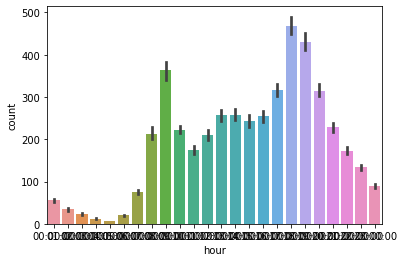

In [ ]:
from numpy import mean
ax = sns.barplot(x='hour', y='count', estimator=mean, data = df_train)

In [ ]:
# plt.figure(figsize=(200,100))
# ax = sns.lineplot(x='date', y='count', estimator=mean, data = df)

In [ ]:
from sklearn import linear_model
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# 保留需要用的欄位
columns = ['temp', 'humidity', 'hour', 'count'] # 用list管理使用的features
df_train_copy = df_train[columns]

# 創造 dummy variables
df_train_copy = pd.get_dummies(df_train_copy)

# 區分測試資料跟訓練資料
train, test = train_test_split(df_train_copy, test_size=0.1, random_state=42)
X_train = train.drop(columns=['count'])
Y_train = train['count']

In [ ]:
# 建立模型(linear regression)
from sklearn.linear_model import Lasso

Lasso = Lasso(alpha=1.0, fit_intercept=False, normalize=False,
                 precompute=False, copy_X=True, max_iter=1000,
                 tol=1e-4, warm_start=False, positive=True,
                 random_state=None, selection='cyclic')
Lasso.fit(X_train, Y_train)

# 印出係數
print("Model slope:", Lasso.coef_)

# 印出截距
print("Model intercept:", Lasso.intercept_)

Model slope: [ 51.24457685   0.          40.08625943  20.13148101  10.99491103
   0.           0.          13.30028129  70.67028947 204.58871788
 349.95300533 204.82718639 150.62919041 178.79813621 219.41314255
 219.24382449 202.99978018 209.54522382 276.20983822 428.58191448
 395.480952   284.32204676 202.34699515 149.49738447 113.87548225
  73.49791872]
Model intercept: 0.0


In [ ]:
# 用測試資料計算準確率
X_test = test.drop(columns=['count'])
Y_test = test['count'].to_frame()
count_predictions = Lasso.predict(X_test)
# MSLE = mean_squared_log_error(Y_test, count_predictions)

In [ ]:
df_test = df[df['count'].isnull()]
df_test_x = df_test[['temp', 'humidity', 'hour']]

df_test_x = pd.get_dummies(df_test_x)

# 套入模型進行預測
count_predictions = Lasso.predict(df_test_x)
df_sumission = df_test['datetime'].to_frame()
df_sumission['count'] = count_predictions

In [ ]:
# df_sumission.to_csv('Bike_share_prediction/answer_v1.csv', index = False)

In [ ]:
# 建立模型(exponential regression)
from sklearn.linear_model import LinearRegression

# 取Log解決預測結果會有負值問題
Y_train_log = np.log(Y_train['count']).to_frame() 

model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train_log)

# 印出係數
print("Model slope:", model.coef_)

# 印出截距
print("Model intercept:", model.intercept_)

Model slope: [[ 0.36603089 -0.08512177 -0.75128243 -1.42135635 -1.92993491 -2.48176696
  -2.76955221 -1.68981661 -0.45947183  0.51027479  1.14893282  0.79961295
   0.43609459  0.52650187  0.70257136  0.663918    0.57623235  0.59741427
   0.88350148  1.2898056   1.22650469  0.96746443  0.68355043  0.45337301
   0.21604092 -0.17861227]]
Model intercept: [4.54216805]


In [ ]:
# 用測試資料計算準確率
X_test = test.drop(columns=['count'])
Y_test = test['count'].to_frame()
count_predictions = np.exp(model.predict(X_test))
MSLE = mean_squared_log_error(Y_test, count_predictions)
print('MSLE = ', MSLE)

MSLE =  0.45434385119457776


In [ ]:
# 用所有測試資料建模
train = pd.concat([train, test])

X_train = train.drop(columns=['count'])
Y_train = train['count'].to_frame()

# 取Log解決預測結果會有負值問題
Y_train_log = np.log(Y_train['count']).to_frame() 

model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train_log)

# 印出係數
print("Model slope:", model.coef_)

# 印出截距
print("Model intercept:", model.intercept_)

Model slope: [[ 0.36906953 -0.08492953 -0.75518124 -1.40465317 -1.94054099 -2.47165531
  -2.77755077 -1.68877404 -0.46595952  0.51874705  1.14293481  0.79331495
   0.44014407  0.54155057  0.70446405  0.66299825  0.56085259  0.60839924
   0.87693666  1.29202225  1.22457624  0.96786255  0.68567479  0.44922573
   0.21661508 -0.18200386]]
Model intercept: [4.54479103]


In [ ]:
df_test_x = df_test[['temp', 'humidity', 'hour']]
df_test_x = pd.get_dummies(df_test_x)

In [ ]:
# 套入模型進行預測
count_predictions = np.exp(model.predict(df_test_x))
df_sumission = df_test['datetime'].to_frame()
df_sumission['count'] = count_predictions

In [ ]:
# df_sumission.to_csv('Bike_share_prediction/answer_v5.csv', index = False)

In [ ]:
# 建立模型(time series + exponential regression)
from sklearn.linear_model import LinearRegression

# 區分測試資料跟訓練資料（前15天當訓練，16-19號當測試）
train =  df_train[(df_train['day'] != '16') & (df_train['day'] != '17') & (df_train['day'] != '18') & (df_train['day'] != '19')]
test =  df_train[(df_train['day'] == '16') | (df_train['day'] == '17') | (df_train['day'] == '18') | (df_train['day'] == '19')]

# 保留需要用的欄位
train = train[['temp', 'humidity', 'hour', 'count', 'premonth_count']]
test = test[['temp', 'humidity', 'hour', 'count', 'premonth_count']]

# 創造 dummy variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# 區分測試資料跟訓練資料
X_train = train.drop(columns=['count'])
Y_train = train['count'].to_frame()

# 取Log解決預測結果會有負值問題
Y_train_log = np.log(Y_train['count']).to_frame() 

model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train_log)

# 印出係數
print("Model slope:", model.coef_)

# 印出截距
print("Model intercept:", model.intercept_)

Model slope: [[ 0.15332712 -0.09689428  0.00497738 -0.78997269 -1.44223042 -2.01994585
  -2.52073908 -2.84198741 -1.7514149  -0.53170005  0.46147798  1.1041027
   0.77674634  0.4406268   0.56237641  0.76201103  0.72951927  0.63694158
   0.68497545  0.9494284   1.35689924  1.27104292  0.99365188  0.69582363
   0.45539603  0.20763851 -0.19066776]]
Model intercept: [3.61009411]


In [ ]:
# 用測試資料計算準確率
X_test = test.drop(columns=['count'])
Y_test = test['count'].to_frame()
count_predictions = np.exp(model.predict(X_test))
MSLE = mean_squared_log_error(Y_test, count_predictions)
print('MSLE = ', MSLE)

MSLE =  0.3669577777511821


In [ ]:
# 用所有測試資料建模
train = pd.concat([train, test])

# 區分測試資料跟訓練資料
X_train = train.drop(columns=['count'])
Y_train = train['count'].to_frame()

# 取Log解決預測結果會有負值問題
Y_train_log = np.log(Y_train['count']).to_frame() 

model = LinearRegression(fit_intercept=True)
model.fit(X_train, Y_train_log)

# 印出係數
print("Model slope:", model.coef_)

# 印出截距
print("Model intercept:", model.intercept_)

Model slope: [[ 0.16416586 -0.09739279  0.00476458 -0.78129295 -1.43950937 -1.9862205
  -2.53045948 -2.84115522 -1.75176893 -0.52804848  0.46354942  1.10346233
   0.77449181  0.4432752   0.56627895  0.74746151  0.72204551  0.63066546
   0.68151712  0.94608634  1.35036555  1.27017017  0.99662416  0.70035405
   0.45207019  0.20913997 -0.19910278]]
Model intercept: [3.65964317]


In [ ]:
df_test_x = df_test[['temp', 'humidity', 'hour', 'premonth_count']]

df_test_x = pd.get_dummies(df_test_x)

# 套入模型進行預測
count_predictions = np.exp(model.predict(df_test_x))
df_sumission = df_test['datetime'].to_frame()
df_sumission['count'] = count_predictions

In [ ]:
# df_sumission.to_csv('Bike_share_prediction/answer_v9.csv', index = False)

In [ ]:
###########以下為資料探勘###########

test.head()

,temp,humidity,count,premonth_count,hour_00:00:00,hour_01:00:00,hour_02:00:00,hour_03:00:00,hour_04:00:00,hour_05:00:00,hour_06:00:00,hour_07:00:00,hour_08:00:00,hour_09:00:00,hour_10:00:00,hour_11:00:00,hour_12:00:00,hour_13:00:00,hour_14:00:00,hour_15:00:00,hour_16:00:00,hour_17:00:00,hour_18:00:00,hour_19:00:00,hour_20:00:00,hour_21:00:00,hour_22:00:00,hour_23:00:00
348,-1.230779,-0.348473,39.0,54.645012,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
349,-1.230779,-0.348473,23.0,54.645012,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
350,-1.230779,-0.348473,16.0,54.645012,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
351,-1.438516,0.325367,15.0,54.645012,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
352,-1.230779,-0.348473,1.0,54.645012,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.groupby('time').count()

KeyError: ignored

In [ ]:
test[test['time'] != 24]

In [ ]:
# todo：temp, humidity, hour三個欄位改為類別型，避免overfitting問題
# todo：視覺化corr低的變數，看可不可以做成類別型
# todo：修改程式碼（嘗試更精簡語法）

###########以下已完成###########
# todo：研究如何避免linear regression出現負值（exponential）
# todo：把testing data放入資料中，就不需要重複資料處理
# todo：嘗試使用time series概念（新增前幾個月的租借量為feature，假設是，前幾個月的銷量有助於預測近幾個月，可能是因為功能有更多人使用了）
# 用groupby做每日平均，再用條件式判斷塞入值
# 做Feature scaling